# Setup

In [1]:
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)

        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow

        self.bc['up']['u'][0] = [[bcu, 'fixed']]
        self.bc['up']['p'] = [[bcp, 'fixed']]

    def setup_constants(self):
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.01),
            'k1' : fd.Constant(0.5),
            'k2' : fd.Constant(0.01),
            'lamd1' : fd.Constant(1.5),
            'lamd2' : fd.Constant(0.),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'f' : fd.Constant(1.),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.)
        }

# Solve

In [5]:
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'T': 1.0
}
)

#define mesh
mesh = fd.Mesh("../../../meshes/step.msh")

# add subsystems
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)

#setup system and define subsystems
solver.setup_bcs()
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up')
solver.define(['cd', 'cs', 'as'], 'cdcsas')

#setup initial condition
x, y = fd.SpatialCoordinate(mesh)
c = fd.conditional(pow(x-1, 2)+pow(y-1.5,2)<0.05*0.05, 10, 0)
solver.setup_initial('cd_n', c, mixedspace=True, index=0)

#solve
solver.solve()

[None, None, None, None, None, None, None, None, None]
['u', 'p', 'u', 'cd', 'cs', 'as']
u up 0
p up 1
cd cdcsas 3
cd cdcsas 4
cs cdcsas 5
cs cdcsas 6
as cdcsas 7
as cdcsas 8
time = 1.000


# Plotting

## Pressure and Velocity

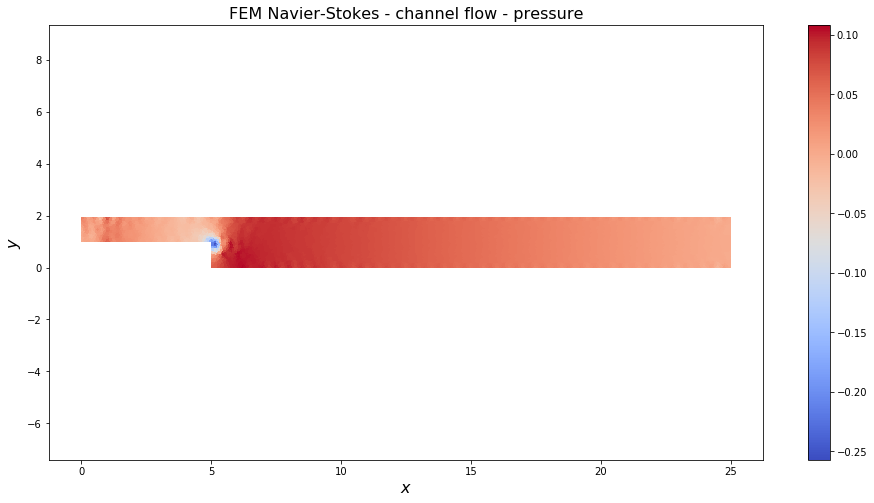

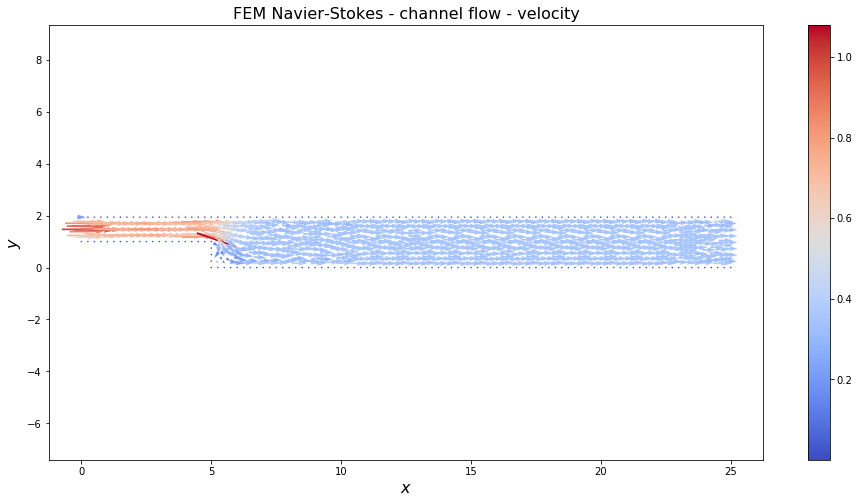

In [11]:
fig1 = plt.figure(figsize=(16, 8))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(solver.form_args['p_'],axes=ax1)
ax1.axis('equal')

fig2 = plt.figure(figsize=(16, 8))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(solver.form_args['u_'],axes=ax2)
ax2.axis('equal');




## Dissolved Phase

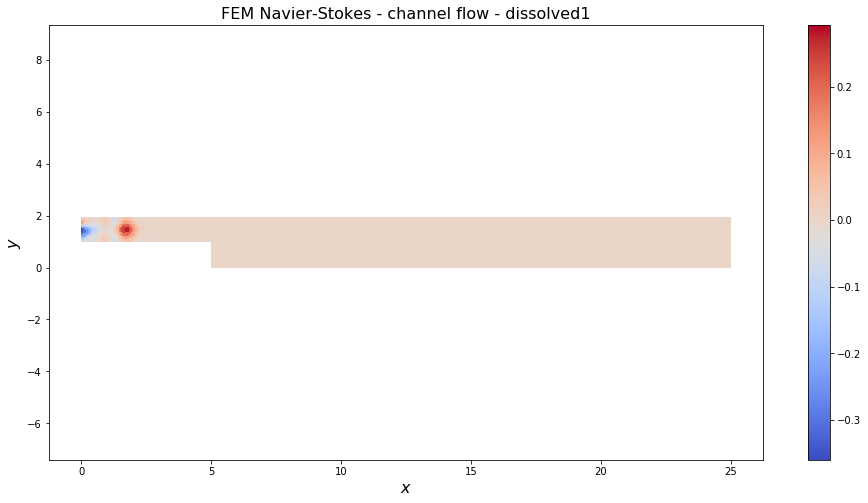

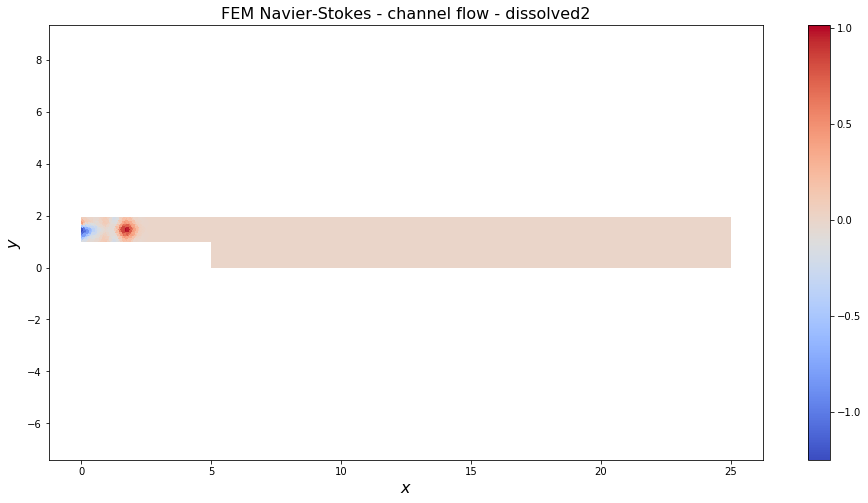

In [16]:
cd1, cd2 = solver.form_args['cd_'].split()

fig3 = plt.figure(figsize=(16, 8))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved1', fontsize=16)
fd.plot(cd1,axes=ax3)
ax3.axis('equal');

fig6 = plt.figure(figsize=(16, 8))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - dissolved2', fontsize=16)
fd.plot(cd2, axes=ax6)
ax6.axis('equal');

## Suspended Phase

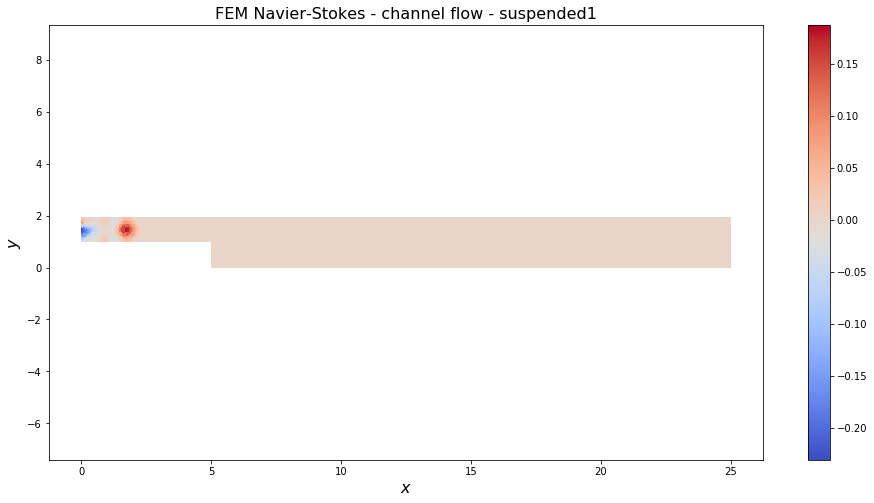

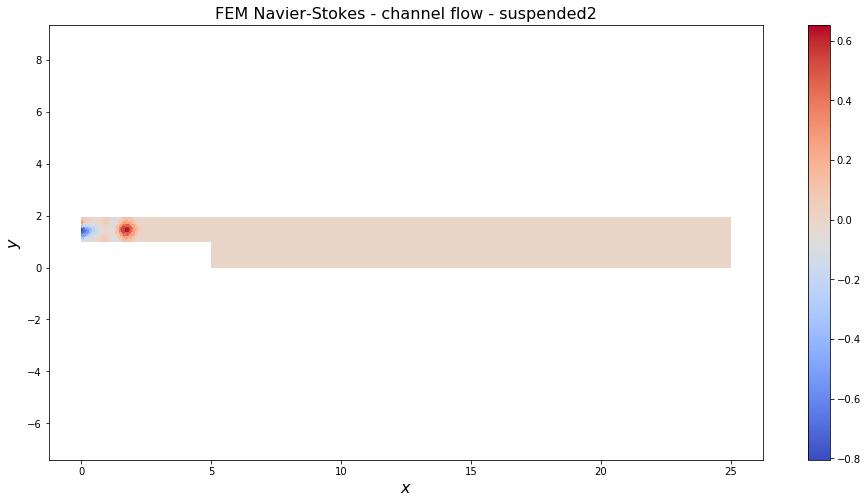

In [17]:
cs1, cs2 = solver.form_args['cs_'].split()

fig4 = plt.figure(figsize=(16, 8))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - suspended1', fontsize=16)
fd.plot(cs1, axes=ax4)
ax4.axis('equal');

fig7 = plt.figure(figsize=(16, 8))
ax7 = fig7.add_subplot(111)
ax7.set_xlabel('$x$', fontsize=16)
ax7.set_ylabel('$y$', fontsize=16)
ax7.set_title('FEM Navier-Stokes - channel flow - suspended2', fontsize=16)
fd.plot(cs2, axes=ax7)
ax7.axis('equal');

## Sediment Phase

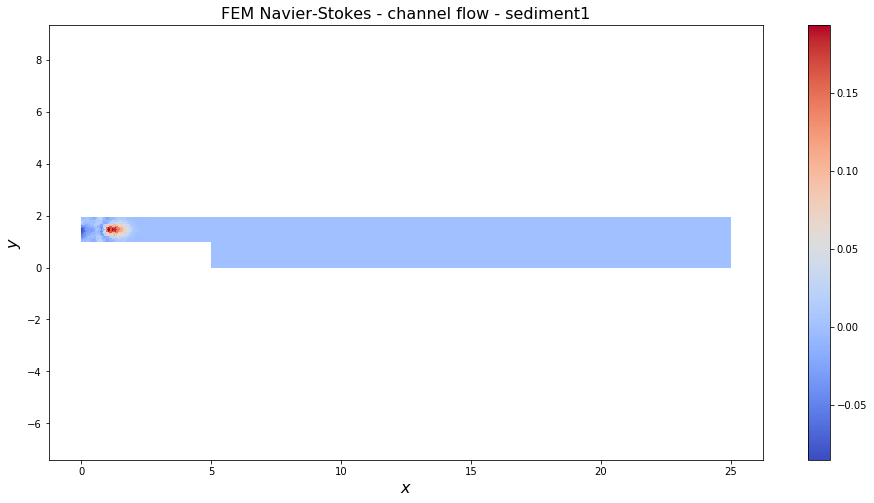

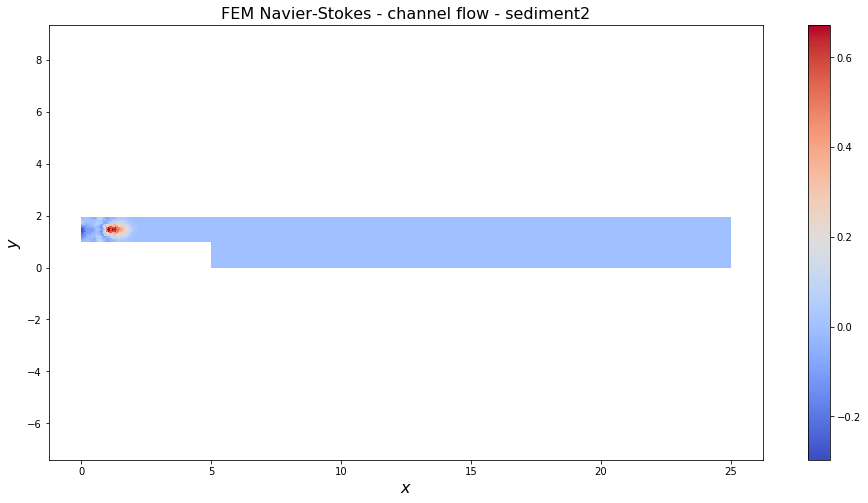

In [18]:
as1, as2 = solver.form_args['as_'].split()

fig5 = plt.figure(figsize=(16, 8))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(as1, axes=ax5)
ax5.axis('equal');

fig8 = plt.figure(figsize=(16, 8))
ax8 = fig8.add_subplot(111)
ax8.set_xlabel('$x$', fontsize=16)
ax8.set_ylabel('$y$', fontsize=16)
ax8.set_title('FEM Navier-Stokes - channel flow - sediment2', fontsize=16)
fd.plot(as2, axes=ax8)
ax8.axis('equal');

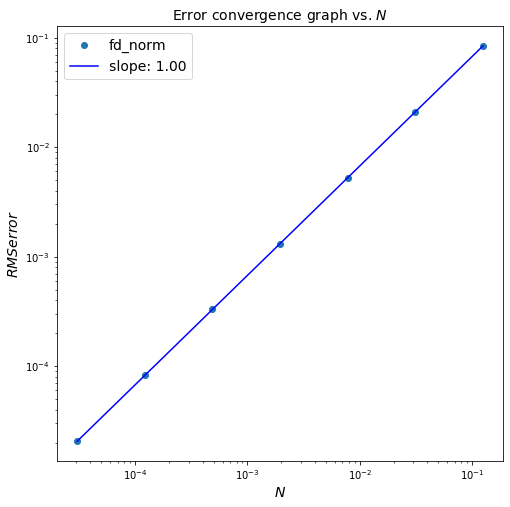

In [9]:
error = []
num_vertices = []
dx_array = []


for i in (2**n for n in range(1, 8)):
    mesh = fd.UnitSquareMesh(i, i)
    Q = fd.FunctionSpace(mesh, 'DG', 1)
    DG0 = fd.FunctionSpace(mesh, 'DG', 0)
    b = fd.Function(DG0).interpolate(fd.CellVolume(mesh))
    mean = b.dat.data.mean()
    
    x = fd.SpatialCoordinate(mesh)
    f = x**2

    u = fd.TrialFunction(Q)
    v = fd.TestFunction(Q)
    c = fd.Function(Q)

    u_exact = fd.interpolate(f, Q)
    
    form = u*v*fd.dx - f*v*fd.dx
    a, L = fd.system(form)
    fd.solve(a == L, c)
    
    error.append(fd.errornorm(u_exact, c))
    num_vertices.append(mesh.num_vertices())
    dx_array.append(mean)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.loglog(dx_array, error, 'o', label='fd_norm')

ax1.set_xlabel('$N$', fontsize=14)
ax1.set_ylabel('$RMS error$', fontsize=14)
ax1.set_title('Error convergence graph vs. $N$', fontsize=14)
ax1.legend(loc='best', fontsize=14)

# line fit

start_fit = 0
line_fit_uniform_fd = np.polyfit(np.log(dx_array[start_fit:]), np.log(error[start_fit:]), 1)

ax1.loglog(dx_array, np.exp(line_fit_uniform_fd[1]) * dx_array**(line_fit_uniform_fd[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_uniform_fd[0]))
ax1.legend(loc='best', fontsize=14)